In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, accuracy_score, f1_score, make_scorer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import chi2_contingency
from xgboost import XGBClassifier
import sklearn 


In [4]:
df = pd.read_csv('../data/raw/cleaned_animal_disease_prediction.csv')
df.head()

,Animal_Type,Breed,Age,Gender,Weight,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Duration,...,Diarrhea,Coughing,Labored_Breathing,Lameness,Skin_Lesions,Nasal_Discharge,Eye_Discharge,Body_Temperature,Heart_Rate,Disease_Prediction
0,Dog,Labrador,4,Male,25.0,Fever,Lethargy,Appetite Loss,Vomiting,3 days,...,No,No,No,No,No,No,No,39.5°C,120,Parvovirus
1,Cat,Siamese,2,Female,4.5,Coughing,Sneezing,Eye Discharge,Nasal Discharge,1 week,...,No,Yes,No,No,No,Yes,Yes,38.9°C,150,Upper Respiratory Infection
2,Cow,Holstein,3,Female,600.0,Fever,Nasal Discharge,Labored Breathing,Coughing,5 days,...,No,Yes,Yes,No,No,Yes,No,40.1°C,90,Foot and Mouth Disease
3,Dog,Beagle,1,Male,10.0,Diarrhea,Vomiting,Lethargy,Appetite Loss,2 days,...,Yes,No,No,No,No,No,No,39.2°C,130,Gastroenteritis
4,Cat,Persian,5,Male,3.8,Lethargy,Appetite Loss,Skin Lesions,No,2 weeks,...,No,No,No,No,Yes,No,No,38.7°C,160,Fungal Infection


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Animal_Type         431 non-null    object 
 1   Breed               431 non-null    object 
 2   Age                 431 non-null    int64  
 3   Gender              431 non-null    object 
 4   Weight              431 non-null    float64
 5   Symptom_1           431 non-null    object 
 6   Symptom_2           431 non-null    object 
 7   Symptom_3           431 non-null    object 
 8   Symptom_4           431 non-null    object 
 9   Duration            431 non-null    object 
 10  Appetite_Loss       431 non-null    object 
 11  Vomiting            431 non-null    object 
 12  Diarrhea            431 non-null    object 
 13  Coughing            431 non-null    object 
 14  Labored_Breathing   431 non-null    object 
 15  Lameness            431 non-null    object 
 16  Skin_Les

In [6]:
contingency_table = pd.crosstab(df['Animal_Type'], df['Symptom_1'])
contingency_table

Symptom_1,Appetite Loss,Coughing,Decreased Milk Yield,Diarrhea,Eye Discharge,Fever,Labored Breathing,Lameness,Lethargy,Loss of Appetite,Nasal Discharge,Skin Lesions,Sneezing,Swollen Joints,Vomiting,Weight Loss
Animal_Type,,,,,,,,,,,,,,,,
Cat,4,21,0,0,7,0,0,0,9,0,16,1,3,0,11,0
Cow,3,40,1,5,0,8,1,0,5,2,1,0,0,0,0,2
Dog,0,14,0,2,0,3,2,4,33,0,0,0,1,0,16,0
Goat,0,0,0,4,0,2,0,0,0,0,1,0,0,0,32,0
Horse,1,5,0,0,0,2,0,50,2,0,1,0,0,3,0,2
Pig,0,33,0,0,0,1,0,0,0,0,0,0,1,0,3,0
Rabbit,0,0,0,1,0,0,0,0,1,0,4,0,28,0,0,0
Sheep,0,28,0,0,0,0,0,1,2,0,0,0,0,5,0,3


In [7]:
chi2, p_value, dof, expected = chi2_contingency(contingency_table.values)

print("Chi-square statistic:", chi2)
print("p-value:", p_value)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

Chi-square statistic: 1074.8845297668736
p-value: 1.5846329638707856e-160
Degrees of freedom: 105
Expected frequencies:
 [[ 1.33642691 23.55452436  0.16705336  2.00464037  1.16937355  2.67285383
   0.50116009  9.18793503  8.68677494  0.33410673  3.84222738  0.16705336
   5.51276102  1.33642691 10.35730858  1.16937355]
 [ 1.26218097 22.24593968  0.15777262  1.89327146  1.10440835  2.52436195
   0.47331787  8.6774942   8.20417633  0.31554524  3.6287703   0.15777262
   5.20649652  1.26218097  9.78190255  1.10440835]
 [ 1.39211137 24.53596288  0.17401392  2.08816705  1.21809745  2.78422274
   0.52204176  9.57076566  9.0487239   0.34802784  4.00232019  0.17401392
   5.7424594   1.39211137 10.78886311  1.21809745]
 [ 0.72389791 12.7587007   0.09048724  1.08584687  0.63341067  1.44779582
   0.27146172  4.97679814  4.70533643  0.18097448  2.0812065   0.09048724
   2.98607889  0.72389791  5.61020882  0.63341067]
 [ 1.225058   21.59164733  0.15313225  1.83758701  1.07192575  2.45011601
   0.4593

In [8]:
animal_dist = df['Animal_Type'].value_counts(normalize=True) * 100
animal_dist

Animal_Type
Dog       17.401392
Cat       16.705336
Cow       15.777262
Horse     15.313225
Sheep      9.048724
Goat       9.048724
Pig        8.816705
Rabbit     7.888631
Name: proportion, dtype: float64

In [9]:
gender_dist = pd.crosstab(df['Animal_Type'], df['Gender'], normalize='index') * 100
gender_dist

Gender,Female,Male
Animal_Type,,
Cat,44.444444,55.555556
Cow,54.411765,45.588235
Dog,46.666667,53.333333
Goat,64.102564,35.897436
Horse,45.454545,54.545455
Pig,47.368421,52.631579
Rabbit,47.058824,52.941176
Sheep,33.333333,66.666667


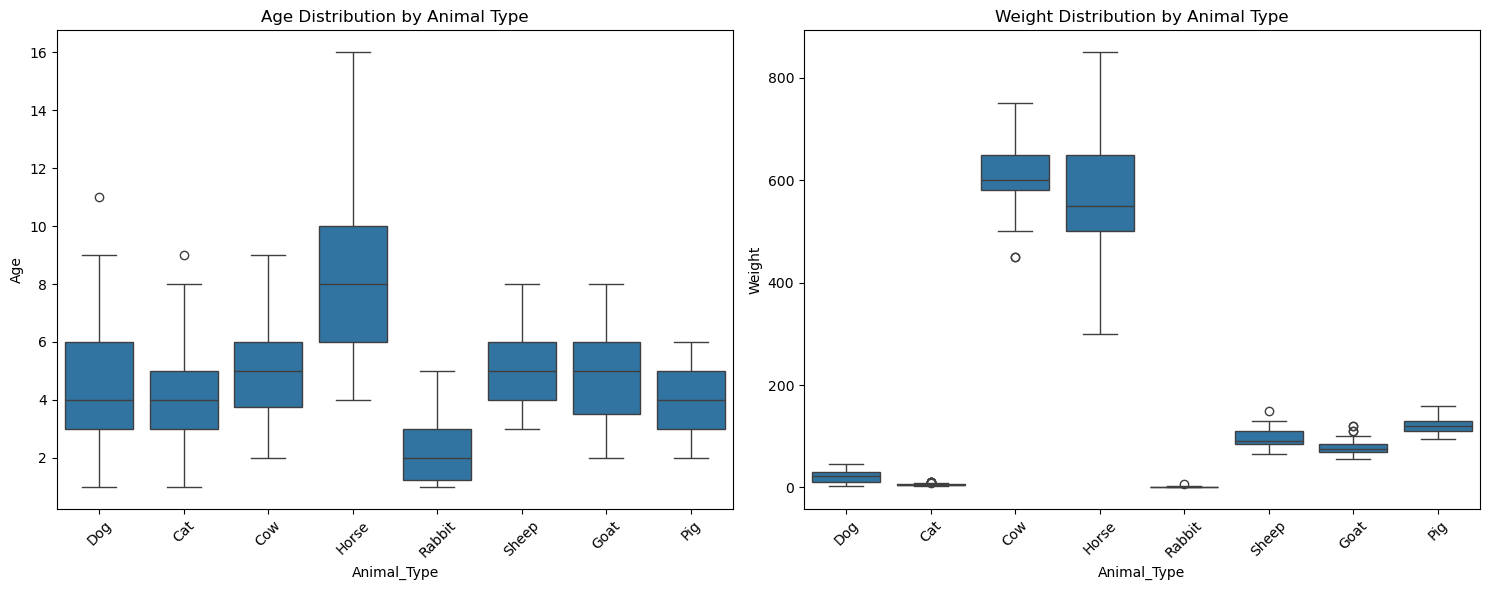

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.boxplot(x='Animal_Type', y='Age', data=df, ax=ax1)
ax1.set_title('Age Distribution by Animal Type')
ax1.tick_params(axis='x', rotation=45)

sns.boxplot(x='Animal_Type', y='Weight', data=df, ax=ax2)
ax2.set_title('Weight Distribution by Animal Type')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

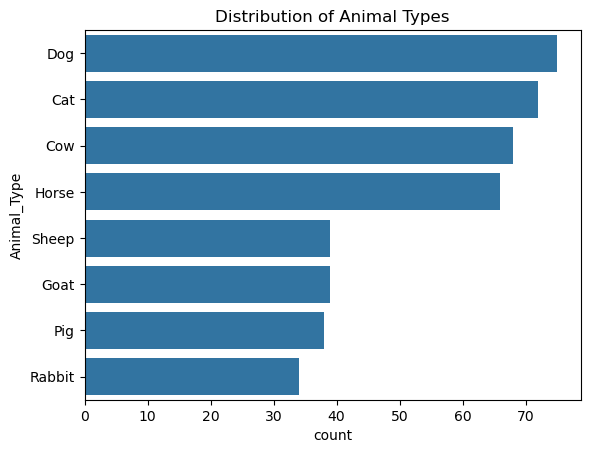

In [11]:
sns.countplot(data=df, y='Animal_Type', order=df['Animal_Type'].value_counts().index)
plt.title('Distribution of Animal Types')
plt.show()

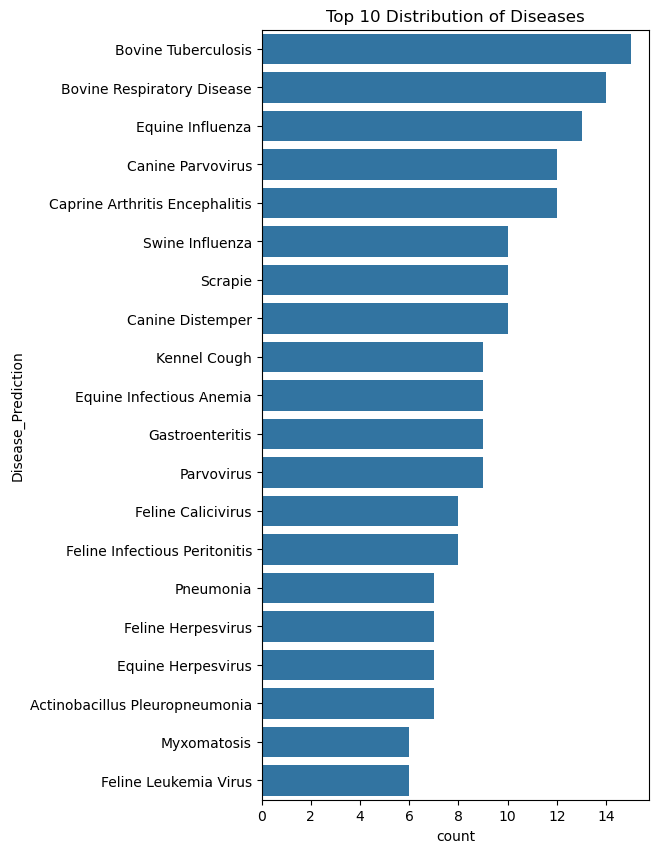

In [12]:
plt.figure(figsize=(5, 10))
sns.countplot(data=df, y='Disease_Prediction', order=df['Disease_Prediction'].value_counts().index[:20])
plt.title('Top 10 Distribution of Diseases')
plt.show()

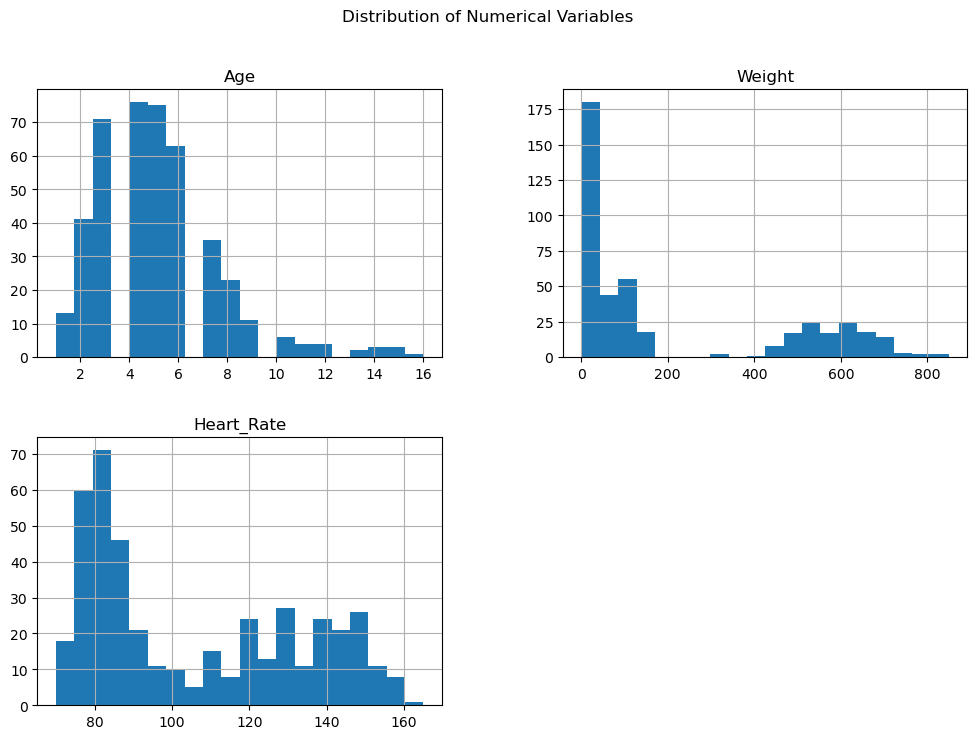

In [13]:
df[['Age', 'Weight', 'Heart_Rate']].hist(bins=20, figsize=(12, 8))
plt.suptitle('Distribution of Numerical Variables')
plt.show()

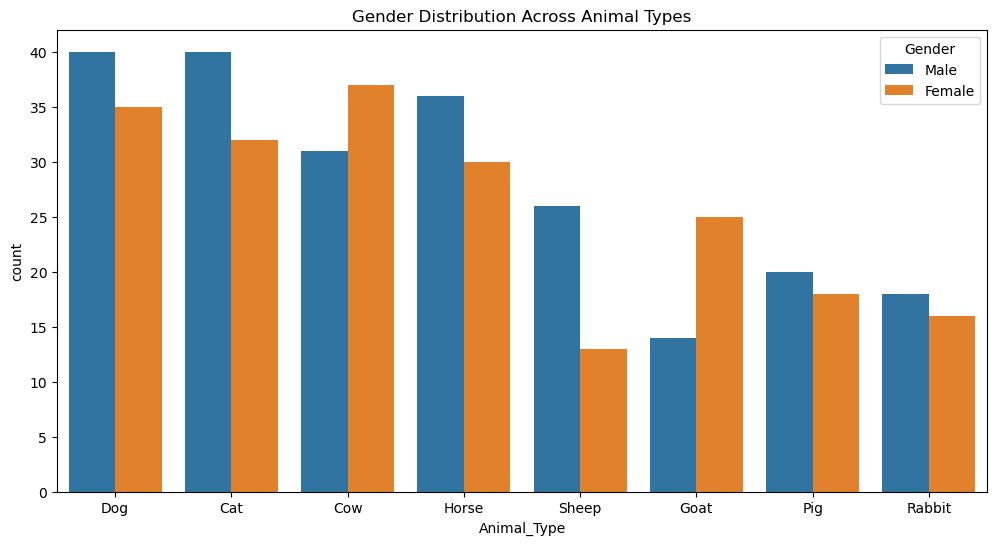

In [14]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Animal_Type', hue='Gender', order=df['Animal_Type'].value_counts().index)
plt.title('Gender Distribution Across Animal Types')
plt.show()

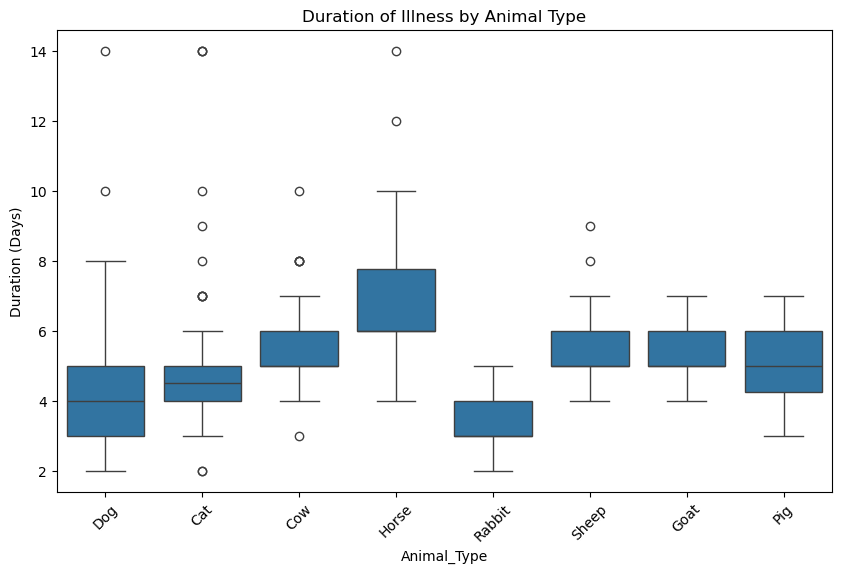

In [15]:
df['Duration_Num'] = df['Duration'].str.extract('(\d+)').astype(float)
df.loc[df['Duration'].str.contains('week'), 'Duration_Num'] *= 7

plt.figure(figsize=(10, 6))
sns.boxplot(x='Animal_Type', y='Duration_Num', data=df)
plt.title('Duration of Illness by Animal Type')
plt.ylabel('Duration (Days)')
plt.xticks(rotation=45)
plt.show()

In [16]:
df.loc[:, 'Duration_Num']

0       3.0
1       7.0
2       5.0
3       2.0
4      14.0
       ... 
426    10.0
427     7.0
428     4.0
429     6.0
430     8.0
Name: Duration_Num, Length: 431, dtype: float64

In [17]:
df['Symptom_1'].unique()

array(['Fever', 'Coughing', 'Diarrhea', 'Lethargy', 'Lameness',
       'Vomiting', 'Labored Breathing', 'Skin Lesions',
       'Decreased Milk Yield', 'Appetite Loss', 'Nasal Discharge',
       'Eye Discharge', 'Sneezing', 'Loss of Appetite', 'Swollen Joints',
       'Weight Loss'], dtype=object)

In [18]:
df['Symptom_2'].unique()

array(['Lethargy', 'Sneezing', 'Nasal Discharge', 'Vomiting',
       'Appetite Loss', 'Labored Breathing', 'Fever', 'Coughing',
       'Decreased Milk Yield', 'Eye Discharge', 'Diarrhea', 'Swelling',
       'Weight Loss', 'Swollen Joints', 'Loss of Appetite', 'Lameness',
       'Dehydration', 'Reduced Milk Production',
       'Reduced Wool Production', 'Swollen Legs'], dtype=object)

In [19]:
df['Symptom_3'].unique()

array(['Appetite Loss', 'Eye Discharge', 'Labored Breathing', 'Lethargy',
       'Skin Lesions', 'Nasal Discharge', 'Fever', 'Vomiting', 'Coughing',
       'Decreased Milk Yield', 'Diarrhea', 'Swollen Joints',
       'Loss of Appetite', 'Reduced Appetite', 'Weight Loss',
       'Dehydration', 'Sneezing', 'Swollen Legs'], dtype=object)

In [20]:
df['Symptom_4'].unique()

array(['Vomiting', 'Nasal Discharge', 'Coughing', 'Appetite Loss', 'No',
       'Fever', 'Lethargy', 'Diarrhea', 'Labored Breathing',
       'Dehydration', 'Sneezing', 'Skin Lesions', 'Decreased Milk Yield',
       'Loss of Appetite', 'Eye Discharge', 'Reduced Appetite',
       'Weight Loss', 'Reduced Milk Production', 'Lameness',
       'Reduced Wool Growth', 'Swollen Joints', 'Reduced Mobility',
       'Swollen Legs'], dtype=object)

Skin Lesions - Common
Labored Breathing - Common


In [29]:
animal_type = df['Animal_Type'].unique()

In [30]:
print(sklearn.__version__)

1.6.1


In [31]:
df.shape

(431, 23)

In [54]:
d = {}
for i in animal_type:
    print(np.unique(df.loc[df['Animal_Type'] == i, 'Breed']))

['Akita' 'Beagle' 'Border Collie' 'Boxer' 'Bulldog' 'Chihuahua'
 'Cocker Spaniel' 'Corgi' 'Dachshund' 'Dalmatian' 'Doberman Pinscher'
 'German Shepherd' 'Golden Retriever' 'Husky' 'Labrador'
 'Labrador Retriever' 'Pit Bull' 'Poodle' 'Rottweiler' 'Shih Tzu'
 'Siberian Husky' 'Yorkshire Terrier']
['Abyssinian' 'American Curl' 'Bengal' 'Bombay' 'British Shorthair'
 'Burmese' 'Devon Rex' 'Maine Coon' 'Manx' 'Persian' 'Ragdoll'
 'Russian Blue' 'Scottish Fold' 'Siamese' 'Siberian' 'Sphynx']
['Aberdeen Angus' 'Angus' 'Ayrshire' 'Belted Galloway' 'Brahman'
 'Brown Swiss' 'Charolais' 'Dexter' 'Guernsey' 'Hereford' 'Holstein'
 'Jersey' 'Limousin' 'Red Angus' 'Red Poll' 'Shorthorn' 'Simmental']
['American Quarter' 'Andalusian' 'Appaloosa' 'Arabian' 'Belgian'
 'Clydesdale' 'Morgan' 'Mustang' 'Paint' 'Percheron' 'Pinto'
 'Quarter Horse' 'Shetland Pony' 'Shire' 'Standardbred' 'Tennessee Walker'
 'Tennessee Walking Horse' 'Thoroughbred' 'Welsh Pony']
['Dutch' 'English Angora' 'English Lop' 'English S

In [47]:
np.unique(df.loc[df['Animal_Type'] == 'Sheep', 'Breed'])

array(['Blackface', 'Border Leicester', 'Cheviot', 'Corriedale', 'Dorper',
       'Dorset', 'Finnsheep', 'Hampshire', 'Karakul',
       'Leicester Longwool', 'Lincoln', 'Merino', 'Rambouillet', 'Romney',
       'Southdown', 'Suffolk', 'Texel', 'Tunis'], dtype=object)

In [52]:
df.columns

Index(['Animal_Type', 'Breed', 'Age', 'Gender', 'Weight', 'Symptom_1',
       'Symptom_2', 'Symptom_3', 'Symptom_4', 'Duration', 'Appetite_Loss',
       'Vomiting', 'Diarrhea', 'Coughing', 'Labored_Breathing', 'Lameness',
       'Skin_Lesions', 'Nasal_Discharge', 'Eye_Discharge', 'Body_Temperature',
       'Heart_Rate', 'Disease_Prediction', 'Duration_Num'],
      dtype='object')